# Annealing by batches

In [3]:
import pandas as pd
import numpy as np

probabilities = np.loadtxt("probabilities.txt", dtype=float, delimiter=" ")


original_array = probabilities.reshape(145, 145, 2)
batch_dimensions = (47, 47, 2)
top_left_pixel_i, top_left_pixel_j = 0, 0
batches = []
indexes = []


for top_left_pixel_i in range(original_array.shape[0] // (batch_dimensions[0] - 2) + 1):
    for top_left_pixel_j in range(
        original_array.shape[1] // (batch_dimensions[1] - 2) + 1
    ):
        if (
            top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            > original_array.shape[0]
        ):
            if (
                top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
                > original_array.shape[1]
            ):
                batch_start_i = original_array.shape[0] - batch_dimensions[0]
                batch_end_i = original_array.shape[0]
                batch_start_j = original_array.shape[1] - batch_dimensions[1]
                batch_end_j = original_array.shape[1]
            else:
                batch_start_i = original_array.shape[0] - batch_dimensions[0]
                batch_end_i = original_array.shape[0]
                batch_start_j = top_left_pixel_j * (batch_dimensions[1] - 2)
                batch_end_j = (
                    top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
                )

        elif (
            top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
            > original_array.shape[1]
        ):
            batch_start_i = top_left_pixel_i * (batch_dimensions[0] - 2)
            batch_end_i = (
                top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            )
            batch_start_j = original_array.shape[1] - batch_dimensions[1]
            batch_end_j = original_array.shape[1]
        else:
            batch_start_i = top_left_pixel_i * (batch_dimensions[0] - 2)
            batch_end_i = (
                top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            )
            batch_start_j = top_left_pixel_j * (batch_dimensions[1] - 2)
            batch_end_j = (
                top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
            )

        indexes.append([(batch_start_i, batch_end_i), (batch_start_j, batch_end_j)])
        batches.append(
            original_array[batch_start_i:batch_end_i, batch_start_j:batch_end_j, :]
        )

In [8]:
lattice_size = 47
# grid_to_chimera(lattice_size, lattice_size)
grid_embedding(lattice_size, lattice_size)

{0: {0, 4},
 47: {2, 6},
 94: {130, 134},
 141: {128, 132},
 188: {256, 260},
 235: {258, 262},
 282: {386, 390},
 329: {384, 388},
 376: {512, 516},
 423: {514, 518},
 470: {642, 646},
 517: {640, 644},
 564: {768, 772},
 611: {770, 774},
 658: {898, 902},
 705: {896, 900},
 752: {1024, 1028},
 799: {1026, 1030},
 846: {1154, 1158},
 893: {1152, 1156},
 940: {1280, 1284},
 987: {1282, 1286},
 1034: {1410, 1414},
 1081: {1408, 1412},
 1128: {1536, 1540},
 1175: {1538, 1542},
 1222: {1666, 1670},
 1269: {1664, 1668},
 1316: {1792, 1796},
 1363: {1794, 1798},
 1410: {1922, 1926},
 1457: {1920, 1924},
 1504: {2048, 2052},
 1551: {2050, 2054},
 1598: {2178, 2182},
 1645: {2176, 2180},
 1692: {2304, 2308},
 1739: {2306, 2310},
 1786: {2434, 2438},
 1833: {2432, 2436},
 1880: {2560, 2564},
 1927: {2562, 2566},
 1974: {2690, 2694},
 2021: {2688, 2692},
 2068: {2816, 2820},
 2115: {2818, 2822},
 2162: {2946, 2950},
 1: {1, 5},
 48: {3, 7},
 95: {131, 135},
 142: {129, 133},
 189: {257, 261},
 

In [15]:
import sys
import os
import argparse
import json
import copy
import time
import matplotlib.animation as animation

from construct_ising import *
from embed_my_implementation import *
from embed_piotr_implementation import *

from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import (
    FixedEmbeddingComposite,
    EmbeddingComposite,
    AutoEmbeddingComposite,
    DWaveSampler,
)


import dimod
from dwave.embedding.chimera import find_grid_embedding


"""
Main program
"""

lattice_size = 47  # 47 works
beta = 0.5
list_samplesets = []

for i in range(len(batches)):
    probabilities = batches[i].reshape(-1, 2)

    external_field, neighbors_coupling = hamiltonian(lattice_size, beta, probabilities)

    sampler_param = {
        "beta_range": [],
        "num_reads": 100,
        "num_sweeps": [],
        "num_sweeps_per_beta": [],
        "beta_schedule_type": ["beta_schedule_options"],
        "seed": [],
        "interrupt_function": [],
        "initial_states": [],
        "initial_states_generator": [],
    }

    # start = time.time()

    # # # COMMENT ONE OF THE TWO ##############################################################################################

    # # My implemented embedding ############################################################################################
    # type = "my_implemented_embedding_{}_{}".format(lattice_size, lattice_size)
    embedding = grid_to_chimera(lattice_size, lattice_size)

    # # # Piotr implemented embedding #########################################################################################
    # type = "piotr_implemented_embedding_{}_{}".format(lattice_size, lattice_size)
    # embedding = grid_embedding(lattice_size, lattice_size)

    # # #######################################################################################################################

    # get sampler properties for debug
    sampler = EmbeddingComposite(
        DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
    )
    qubits = sampler.properties["child_properties"]["qubits"]
    couplers = sampler.properties["child_properties"]["couplers"]

    structured_sampler = FixedEmbeddingComposite(
        dimod.StructureComposite(SimulatedAnnealingSampler(), qubits, couplers),
        embedding,
    )
    sampleset = structured_sampler.sample_ising(
        external_field, neighbors_coupling, num_reads=sampler_param["num_reads"]
    )

    list_samplesets.append(sampleset)

    break

DisconnectedChainError: chain for 0 is not connected

In [41]:
result_samples = []
result_energy = []
for sampleset in list_samplesets:
    result_samples.append(np.array(list(sampleset.first.sample.values())))
    result_energy.append(sampleset.first.energy)

In [116]:
# import pickle

# with open("list_samplesets_new", "wb") as fp:   #Pickling
#     pickle.dump(list_samplesets, fp)

In [78]:
# import copy

# backup_result_samples = [
#     copy.deepcopy(result_samples[i]) for i in range(len(result_samples))
# ]

In [108]:
final_np_array = np.zeros([original_array.shape[0], original_array.shape[1]])
for i in range(len(result_samples)):
    # 0- Initialisations for current batch
    i_range, j_range = indexes[i]
    batch = result_samples[i].reshape(47, 47)

    # 1- Neutralise unwanted values
    if i_range[0] != 0:
        batch[i_range[0] : i_range[0] + 1, :] = 0
    if i_range[1] != original_array.shape[1]:
        batch[i_range[1] - 1 : i_range[1], :] = 0
    if j_range[0] != 0:
        batch[:, j_range[0] : j_range[0] + 1] = 0
    if j_range[1] != original_array.shape[1]:
        batch[:, j_range[1] - 1 : j_range[1]] = 0

    # 2- Add batch to final np array
    final_np_array[i_range[0] : i_range[1], j_range[0] : j_range[1]] += batch

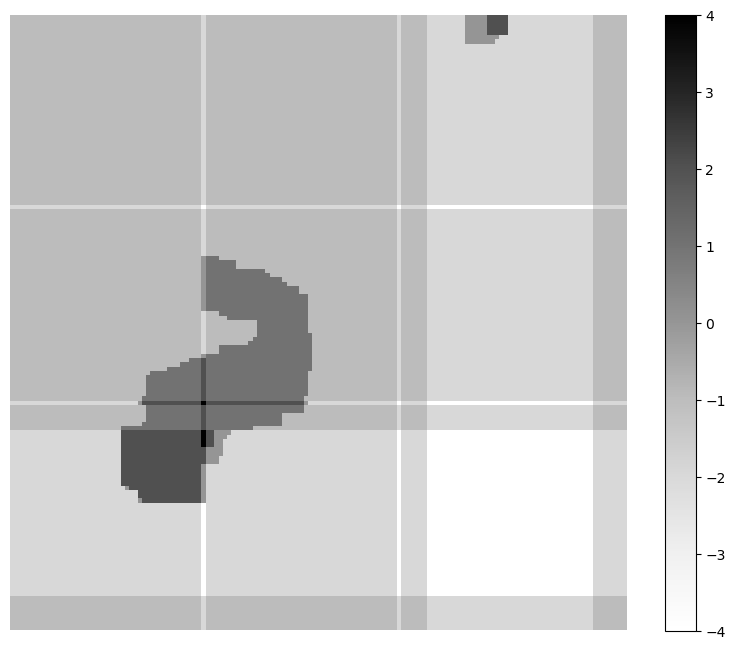

In [114]:
# def plot_image(y, fig_name):
#     """
#     Plot the segmented image
#     """

#     plt.figure(figsize=(10, 8))
#     plt.imshow(y, cmap="Greys")
#     plt.colorbar()
#     plt.axis("off")
#     plt.savefig(fig_name)
#     plt.show()


clmap = final_np_array.astype("float")
plot_image(clmap, "dwave_quantum_annealing_segmentation.png")

# print("Energy :{}".format(result_energy))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
import sys
import os
import argparse
import json
import copy
import time
import matplotlib.animation as animation

from construct_ising import *
from embed_my_implementation import *
from embed_piotr_implementation import *

from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import (
    FixedEmbeddingComposite,
    EmbeddingComposite,
    AutoEmbeddingComposite,
    DWaveSampler,
)


import dimod
from dwave.embedding.chimera import find_grid_embedding


"""
Main program
"""

lattice_size = 1  # 47 works
beta = 0.5

probabilities = np.loadtxt("probabilities.txt", dtype=float, delimiter=" ")

external_field, neighbors_coupling = hamiltonian(lattice_size, beta, probabilities)

sampler_param = {
    "beta_range": [],
    "num_reads": 100,
    "num_sweeps": [],
    "num_sweeps_per_beta": [],
    "beta_schedule_type": ["beta_schedule_options"],
    "seed": [],
    "interrupt_function": [],
    "initial_states": [],
    "initial_states_generator": [],
}

# start = time.time()

# sampler = AutoEmbeddingComposite(
#     # SimulatedAnnealingSampler()
#     DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
# )

sampler = EmbeddingComposite(
    # SimulatedAnnealingSampler()
    DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
)
sampleset = sampler.sample_ising(
    external_field, neighbors_coupling, num_reads=sampler_param["num_reads"]
)

In [2]:
# q = np.loadtxt("./qubits.txt", dtype=float, delimiter=" ")
# c = np.loadtxt("./couplers.txt", dtype=float, delimiter=",")

In [3]:
# sampler = EmbeddingComposite(
#     # SimulatedAnnealingSampler()
#     DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
# )
# qubits = sampler.properties['child_properties']["qubits"]
# q = np.array(qubits)
# ret = np.savetxt("qubits.txt", q, delimiter=",")
# couplers = sampler.properties['child_properties']["couplers"]
# c = np.array(couplers)
# ret = np.savetxt("couplers.txt", c, delimiter=",")

In [16]:
# print("Elapsed wall time : {} ms".format((time.time() - start) * 100))

result_sample = sampleset.first.sample
result_energy = sampleset.first.energy

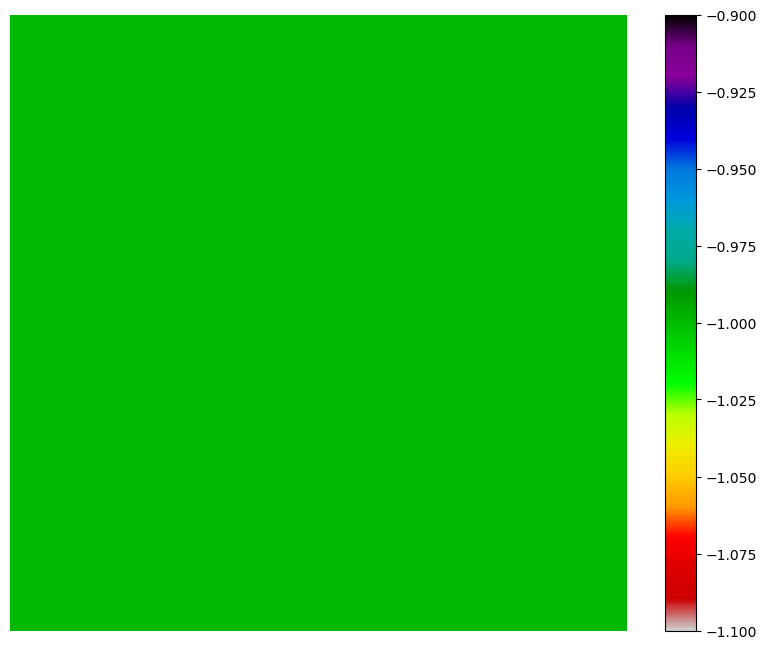

Energy :-11269.473716735492


In [17]:
clmap = (
    np.array(list(result_sample.values()))
    .reshape(lattice_size, lattice_size)
    .astype("float")
)
plot_image(clmap, "dwave_quantum_annealing_segmentation.png")

print("Energy :{}".format(result_energy))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
import dimod
from dwave.system import FixedEmbeddingComposite
from construct_ising import *

# from draw_chimera import *
from embed_my_implementation import *
from embed_piotr_implementation import *
import matplotlib.pyplot as plt
from dimod.serialization.format import Formatter

In [2]:
# ising coefficient
lattice_size = 32
size = 32
rows = 32
columns = 32
beta = 0.5
probabilities = np.loadtxt("probabilities.txt", dtype=float, delimiter=" ")
external_field, neighbors_coupling = hamiltonian(lattice_size, beta, probabilities)

In [3]:
from dwave.system import DWaveSampler
from dwave.system import (
    FixedEmbeddingComposite,
    EmbeddingComposite,
    AutoEmbeddingComposite,
)
from dwave.samplers import SimulatedAnnealingSampler


sampler = DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
# sampler = AutoEmbeddingComposite(sampler)

node_list = sampler.properties["qubits"]
edge_list = []
for duo in sampler.properties["couplers"]:
    edge_list.append((duo[0], duo[1]))

In [10]:
sampler = dimod.StructureComposite(SimulatedAnnealingSampler(), node_list, edge_list)

In [15]:
sampleset = sampler.sample_ising(
    external_field,
    neighbors_coupling
    # num_reads=1,
    # label="final",
)

BinaryQuadraticModelStructureError: given bqm has at least one variable, 0, not supported by the structured solver

In [ ]:
result_sample = sampleset.first.sample
result_energy = sampleset.first.energy

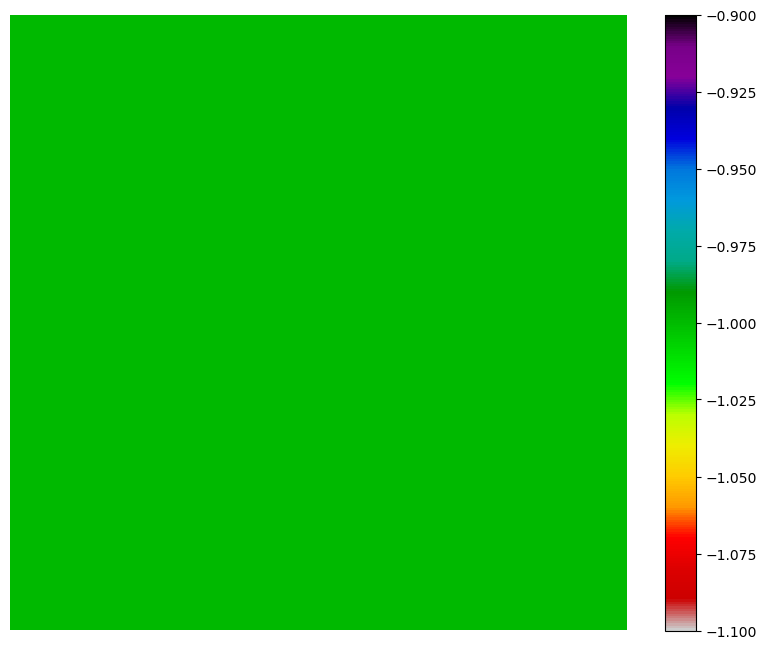

Energy :-3360.655808202363


In [ ]:
clmap = (
    np.array(list(result_sample.values()))
    .reshape(lattice_size, lattice_size)
    .astype("float")
)
plot_image(clmap, "test.png")

print("Energy :{}".format(result_energy))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [4]:
peg_size = 16
# G = dnx.pegasus_graph(peg_size)
H = dnx.pegasus_graph(
    peg_size,
    node_list=sampler.properties["qubits"],
    edge_list=sampler.properties["couplers"],
    check_node_list=True,
    check_edge_list=True,
)

In [5]:
type = "piotr_implemented_embedding_{}_{}".format(rows, columns)

In [6]:
embedding = grid_embedding(rows, columns)
# embedding

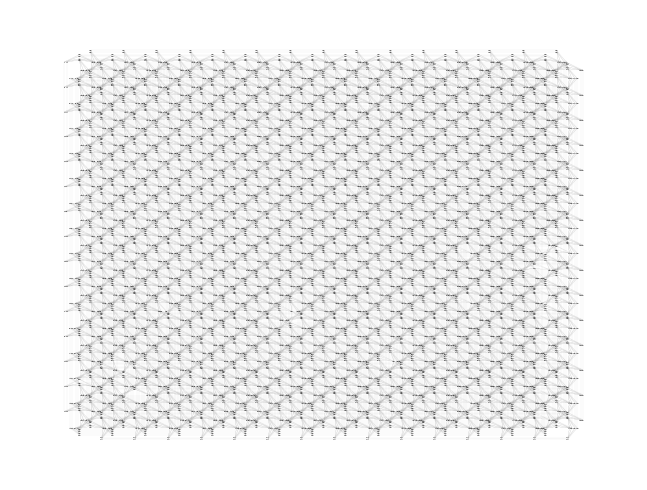

In [20]:
dnx.draw_pegasus(
    H,
    with_labels=True,
    font_size=1,
    width=0.025,
    node_size=0,
    alpha=1,
    crosses=False,
)
plt.savefig(type + "onlypeg", dpi=2000)

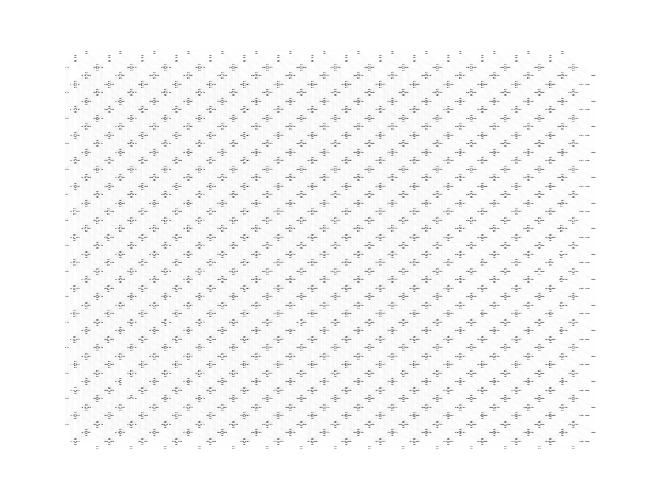

In [9]:
dnx.draw_pegasus_embedding(
    H,
    emb=embedding,
    with_labels=True,
    font_size=1,
    width=0.025,
    node_size=0,
    alpha=1,
    crosses=True,
)
plt.savefig(type, dpi=2000)

In [2]:
# # Visualization
# f, axes = plt.subplots(1, 1)
# dnx.draw_pegasus(
#     G,
#     with_labels=True,
#     crosses=True,
#     node_color="Yellow",
#     width=0.025,
#     node_size=0,
#     alpha=1,
#     ax=axes,
# )
# dnx.draw_pegasus(
#     H,
#     crosses=True,
#     node_color="b",
#     style="dashed",
#     edge_color="b",
#     width=0.025,
#     node_size=0,
#     alpha=1,
#     ax=axes,
# )

# type = "test_pegasus_{}".format(peg_size)
# plt.savefig(type, dpi=2000)

In [4]:
# # COMMENT ONE OF THE TWO ##############################################################################################

# # My implemented embedding ############################################################################################
# type = "my_implemented_embedding_{}_{}".format(rows, columns)
# embedding = grid_to_chimera(rows, columns)

# # Piotr implemented embedding #########################################################################################
type = "piotr_implemented_embedding_{}_{}".format(rows, columns)
embedding = grid_embedding(rows, columns)

# #######################################################################################################################

In [3]:
structured_sampler = dimod.StructureComposite(
    dimod.SimulatedAnnealingSampler(), chimera.nodes, chimera.edges
)